# Infinite Horizon Dynamic Programming - Problem Set 2

### Overview and implementation of policy iteration and value iteration

Spencer Bertsch  
6.7920 - MIT  
Fall 2023

In [231]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import math

from matplotlib.pyplot import figure
# plt.style.use("fivethirtyeight")
plt.style.use("seaborn-white")
from sklearn.metrics import mean_squared_error

import matplotlib.cm as cm
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('text', usetex=False)

In [232]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

## Problem 3

Define the recursive function that represents the variable length treasure hunt problem 

- $n$ represents the number of nodes
- $\gamma$ represents the discount rate 
- $s$ represents the current state in the MDP from 1 to $n$

In [280]:
# define the length of the chain
def luffy_treasure(s: int, gamma: float, N: int):
    """
    :param: s, int representing the current state in the chain between 1 and N
    """
    
    # base case
    if s == (N-1):
        return 2*N
    
    # recursive case
    else:
        return -2 + (gamma*luffy_treasure(s = s+1, gamma=gamma, N=N))
    

In [281]:
v_s0 = luffy_treasure(s=2, gamma=gamma, N=3)
v_s0

6

In [282]:
# driver code
for N in list(range(7, 11, 1)):
    gamma = 1
    v_s0 = luffy_treasure(s=2, gamma=gamma, N=N)
    print(f'N: {N}, V_s0: {v_s0}')

N: 7, V_s0: 6
N: 8, V_s0: 6
N: 9, V_s0: 6
N: 10, V_s0: 6


In [283]:
# generate some results for plotting and store them in a np.array: A
A = np.zeros((6, 50))
for i, N in enumerate(list(range(3, 9, 1))):
    print(f'N:{N}')
    for j, gamma in enumerate(list(range(1, 51, 1))):
        gamma = 0.02 * gamma

        val = luffy_treasure(s=2, gamma=gamma, N=N)
        A[i][j] = val

N:3
N:4
N:5
N:6
N:7
N:8


In [284]:
# we need to normalize the values of X so that they range from 0 to 1
XX = list(range(1, 51, 1))
X = [x*0.02 for x in XX]

Plot the results

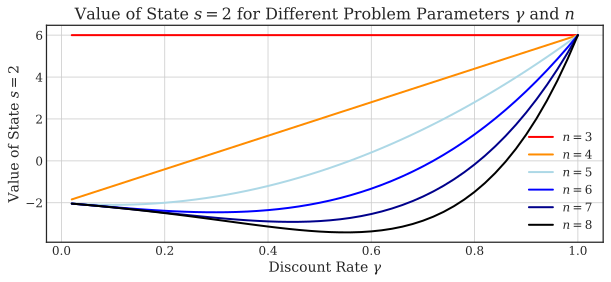

In [285]:
figure(figsize=(10, 4), dpi=80)
plt.plot(X, A[0, :], label = "$n=3$", linestyle="-", color='red', linewidth=2.0)
plt.plot(X, A[1, :], label = "$n=4$", linestyle="-", color='darkorange', linewidth=2.0)
plt.plot(X, A[2, :], label = "$n=5$", linestyle="-", color='lightblue', linewidth=2.0)
plt.plot(X, A[3, :], label = "$n=6$", linestyle="-", color='blue', linewidth=2.0)
plt.plot(X, A[4, :], label = "$n=7$", linestyle="-", color='darkblue', linewidth=2.0)
plt.plot(X, A[5, :], label = "$n=8$", linestyle="-", color='black', linewidth=2.0)
plt.title(f'Value of State $s=2$ for Different Problem Parameters $\gamma$ and $n$', fontsize=16)
plt.xlabel(f'Discount Rate $\gamma$', fontsize=14)
plt.ylabel(f'Value of State $s=2$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Policy Iteration

We have the following inputs: 

- reward function ($-2$ for right, $-1$ for left, $2n$ for right into absorbing node, $0$ while in absorbing nodes)  
- transition function $p(s'|s,a)$, $p(s+1|s=s, a=\text{right})=1, p(s-1|s=s, a=\text{left})=1$
- discount factor $\gamma$ 
- Convergence threshold $\theta$, a small constant 
- policy: $\pi(s)$
- value function: $v(s)$

In [161]:
# define the number of states in the mdp
n = 5

# define the finite state space 
states: list = list(range(0, n, 1))

# define delta
delta = 0.0

# define gamma
gamma = 0.99999

# define theta
theta = 0.001

# define number of epochs used for training 
epochs = 100

# define action space
action_space = [0, 1]

# define the value function as a numpy array indexed by state 
V_s = np.random.randn(n)

# define the starting policy 
policy = np.zeros((n))

# define the matrix Q(s, a)
Q = np.zeros((len(states), len(action_space)))

In [162]:
# this is how we would retrieve the value for state 2
# remember that python is zero indexed (unlike matlab) 
s = n-1
V_s[s]

-1.071182476317365

In [163]:
# define the starting policy 
policy = np.zeros((n))
policy

array([0., 0., 0., 0., 0.])

In [164]:
# define the matrix Q(s, a)
Q = np.zeros((len(states), len(action_space)))
Q

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

### Define the MDP that we will be solving 

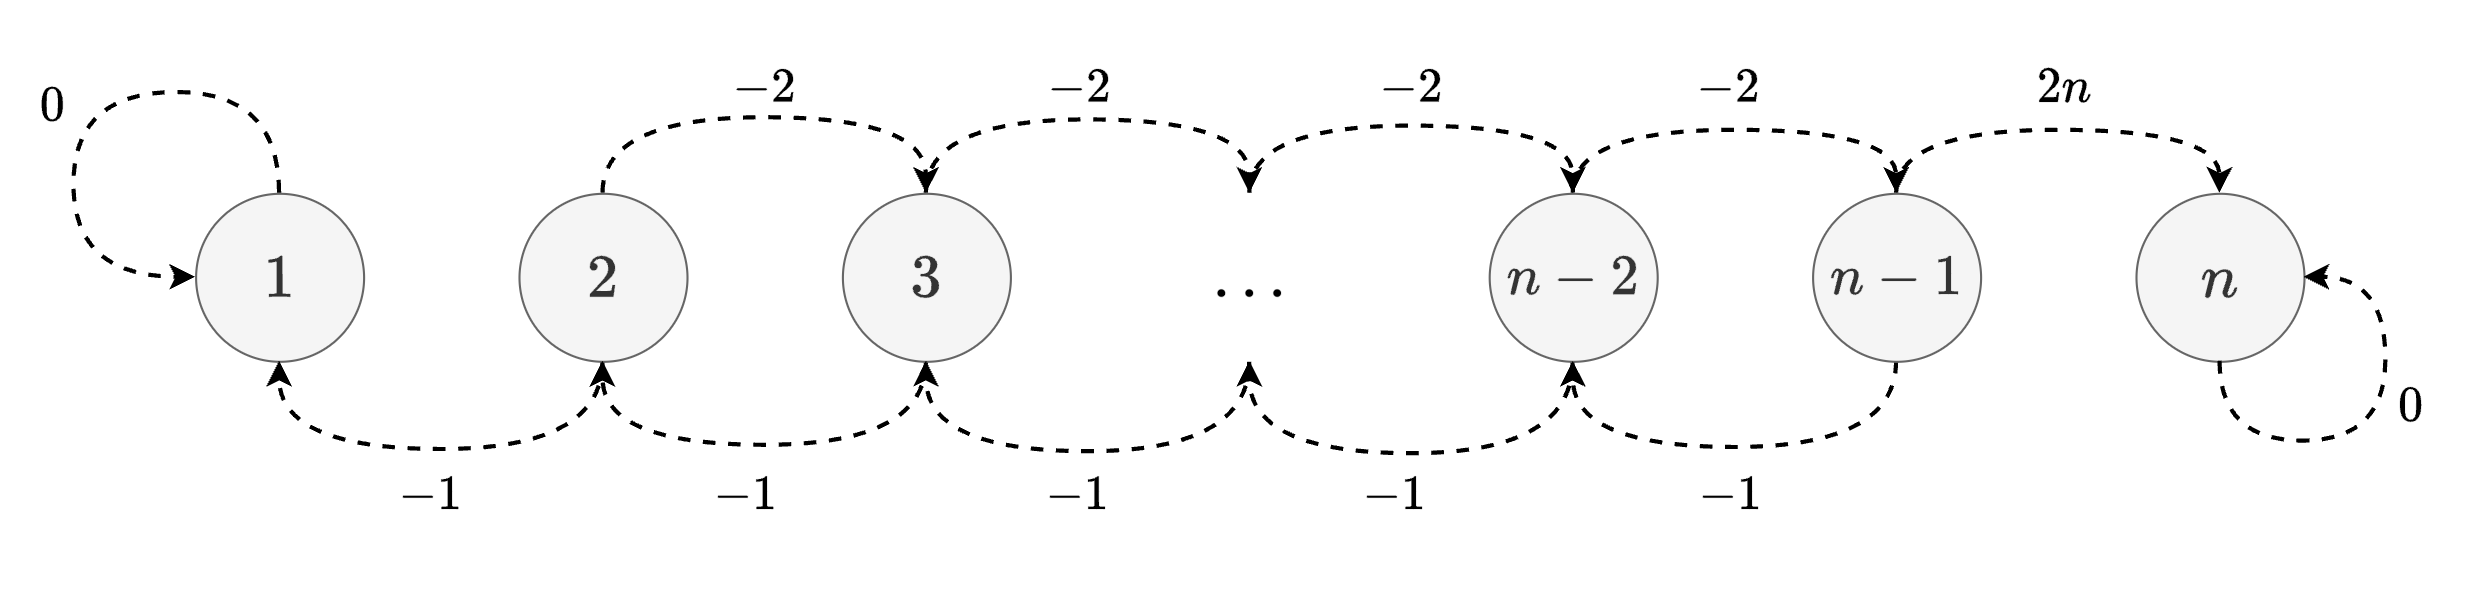

In [165]:
def get_value(s: int, gamma: float, N: int, action: int):
    """
    :param: s, int representing the current state in the chain between 1 and N
    """
    # base case 1
    if s == (N-1):
        return 0
    
    # base case 2
    if ((s == (N-2)) & (action==1)):
        return 2*(n)
    
    # base case 3
    if s == 0:
        return 0
    
    # recursive case
    else:
        
        if action == 1:             
            # go right into another internal node 
            return -2 + (gamma*get_value(s = s+1, gamma=gamma, N=N, action=action))
        
        else: 
            # go left 
            return -1 + (gamma*get_value(s = s-1, gamma=gamma, N=N, action=action))

In [166]:
get_value(s=4, gamma=gamma, N=n, action=1)

0

In [167]:
get_value(s=4, gamma=gamma, N=n, action=0)

0

In [168]:
def policy_evaluation(policy, V_s, theta):
    """
    Evaluate the current policy by generating V_s using the current policy
    """
    cnt = 0
    while True:
        
        # initialize delta to zero 
        delta = 0.0
        cnt += 1
        for state in states:

            # define the current values for each state in the MDP
            previous_value: float = V_s[state]

            # calculate the value of each state V(s) for the current state in the MDP
            current_value = get_value(s=state, gamma=gamma, N=n, action=policy[s])

            V_s[state] = current_value

            # define delta as the max of the current value and the difference between the value functions
            delta = max(delta, abs(previous_value - current_value))
            
        if delta < theta: 
            break
    
    # return V_s
    return V_s, cnt


In [169]:
# demo policy evaluation
V_s, cnt = policy_evaluation(policy=policy, V_s=V_s, theta=theta)
print(f'Count: {cnt}, V(s): {V_s}')

Count: 2, V(s): [ 0.      -1.      -1.99999 -2.99997  0.     ]


In [170]:
# policy iteration
def policy_improvement(V_s: np.array, policy: np.array, max_iter: int = 200, theta: float = 0.001):
    """
    Greedy policy improvement step
    """
    
    policy_updated = False

    # define the current state values given the current policy 
    V_s, val_cnt = policy_evaluation(policy=policy, V_s=V_s, theta=theta)
    
    # initialize the count that will be used to track the number of policy updates
    cnt=0

    # iterate over all states in the finite state space 
    for state in states: 

        # retrieve the action for the current policy gien the current state 
        old_action = policy[state]
        
        # initialize the temp values for all the actions available at the current state (Q(s, a))
        temp_values = np.zeros(len(action_space))

        # iterate over all actions in the action space 
        for action_idx, action in enumerate(action_space):

            # here we compute each Q(s,a) value and fill in the Q table 
            new_value = get_value(s=state, gamma=gamma, N=n, action=action)
            temp_values[action_idx] = new_value

        # now that we have filled in the Q table, we can find the action that maximizes value 
        new_action = np.argmax(temp_values)

        policy[state] = new_action


        if old_action != new_action: 
            policy_updated = True
            cnt += 1

    return policy, cnt
            

In [171]:
# run policy iteration once 
policy, cnt = policy_improvement(V_s=V_s, policy=policy, max_iter=100, theta=0.001)

In [172]:
policy

array([0., 1., 1., 1., 0.])

In [180]:
# define the number of states in the mdp
n = 12

# define the finite state space 
states: list = list(range(0, n, 1))

# define delta
delta = 0.0

# define gamma
gamma = 0.99999

# define theta
theta = 0.001

# define number of epochs used for training 
epochs = 100

# define action space
action_space = [0, 1]

# define the value function as a numpy array indexed by state 
V_s = np.random.randn(n)

# define the starting policy 
policy = np.zeros((n))

# define the matrix Q(s, a)
Q = np.zeros((len(states), len(action_space)))

In [181]:
def train_policy_iteration(V_s: np.array, policy: np.array, epochs: int = 200, theta: float = 0.001):
    # print(f'Policy Evaluation Initiated. \nParameters: \nTheta: {theta} \nGamma: {gamma} \n')
    
    # run initial policy evaluation for the starting policy 
    V_s, value_update_cnt = policy_evaluation(policy=policy, V_s=V_s, theta=theta)
    # log a history of the evaluations needed
    eval_count_history = [cnt]
    
    # run policy iteration once 
    policy, policy_update_cnt = policy_improvement(V_s=V_s, policy=policy, max_iter=100, theta=theta)
    policy_update_history = [policy_update_cnt]
    
    # iterate until we reach convergence 
    for i in range(1, epochs, 1):
        
        # run initial policy evaluation
        V_s, value_update_cnt = policy_evaluation(policy=policy, V_s=V_s, theta=theta)
        eval_count_history.append(value_update_cnt)
        
        # run policy improvement 
        policy, policy_update_cnt = policy_improvement(V_s=V_s, policy=policy, max_iter=100, theta=theta)
        policy_update_history.append(policy_update_cnt)
        
        if policy_update_cnt == 0:
            break
    
    print(f'Epochs needed before convergence: {i}')
    print(f'State-value update history: {eval_count_history}')
    print(f'Policy update history: {policy_update_history}')
    
    print(f'V_s: {np.round(V_s)}')
    print(f'Policy: {policy}')
    
    return sum(policy_update_history)
    

In [182]:
train_policy_iteration(V_s=V_s, policy=policy, epochs=epochs, theta=theta)

Epochs needed before convergence: 1
State-value update history: [3, 2]
Policy update history: [10, 0]
V_s: [ 0.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24.  0.]
Policy: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


10

In [183]:
policy

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [184]:
V_s, value_update_cnt = policy_evaluation(policy=policy, V_s=V_s, theta=theta)

In [185]:
np.round(V_s)

array([ 0.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,  0.])

In [220]:
n_list = []
n_policy_updatesList = []

for n in range(5, 15, 1):
    
    # define the finite state space 
    states: list = list(range(0, n, 1))

    # define the value function as a numpy array indexed by state 
    V_s = np.random.randn(n)

    # define the starting policy 
    policy = np.zeros((n))

    # define the matrix Q(s, a)
    Q = np.zeros((len(states), len(action_space)))
    
    num_policy_updates = train_policy_iteration(V_s=V_s, policy=policy, epochs=epochs, theta=theta)
    n_list.append(n)
    n_policy_updatesList.append(num_policy_updates)


Epochs needed before convergence: 1
State-value update history: [3, 1]
Policy update history: [3, 0]
V_s: [ 0. -1. -2. -3.  0.]
Policy: [0. 1. 1. 1. 0.]
Epochs needed before convergence: 1
State-value update history: [3, 2]
Policy update history: [4, 0]
V_s: [ 0.  6.  8. 10. 12.  0.]
Policy: [0. 1. 1. 1. 1. 0.]
Epochs needed before convergence: 1
State-value update history: [3, 2]
Policy update history: [5, 0]
V_s: [ 0.  6.  8. 10. 12. 14.  0.]
Policy: [0. 1. 1. 1. 1. 1. 0.]
Epochs needed before convergence: 1
State-value update history: [3, 2]
Policy update history: [6, 0]
V_s: [ 0.  6.  8. 10. 12. 14. 16.  0.]
Policy: [0. 1. 1. 1. 1. 1. 1. 0.]
Epochs needed before convergence: 1
State-value update history: [3, 2]
Policy update history: [7, 0]
V_s: [ 0.  6.  8. 10. 12. 14. 16. 18.  0.]
Policy: [0. 1. 1. 1. 1. 1. 1. 1. 0.]
Epochs needed before convergence: 1
State-value update history: [3, 2]
Policy update history: [8, 0]
V_s: [ 0.  6.  8. 10. 12. 14. 16. 18. 20.  0.]
Policy: [0. 1. 1.

In [224]:
yint = range(min(n_policy_updatesList), math.ceil(max(n_policy_updatesList))+1)
xint = range(min(n_list), math.ceil(max(n_list))+1)

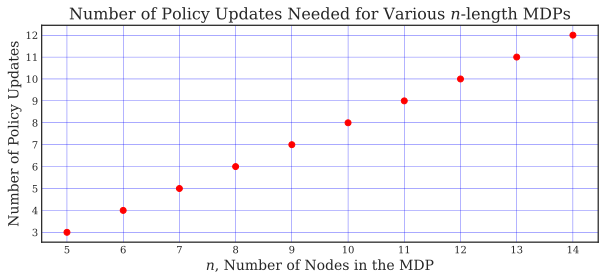

In [228]:
figure(figsize=(10, 4), dpi=80)
plt.plot(n_list, n_policy_updatesList, 'o', color='red')
  
plt.title(f'Number of Policy Updates Needed for Various $n$-length MDPs', fontsize=16)
plt.xlabel(f'$n$, Number of Nodes in the MDP', fontsize=14)
plt.ylabel(f'Number of Policy Updates', fontsize=14)
plt.grid(color='b', linestyle='-', linewidth=0.3)
plt.yticks(yint)
plt.xticks(xint)
plt.show()

# Value Iteration

# Problem 2

In [230]:
epsilon = 1
gamma = 0.5

cost = []

for i in range(3):
    c = 2 * epsilon * gamma
    cost.append(c)
    
cost

[1.0, 1.0, 1.0]